# 규제가 있는 선형회귀 - 릿지, 라쏘, 엘라스틱넷 회귀

#### 규제가 있는 모델 구축 - 당뇨병 데이터세트
#### 1. 데이터 전처리
#### 2. Ridge, Lasso, Elasticnet regression 구축: 회귀 계수 확인, 하이퍼 파라미터 탐색
#### 3. 교차 검증으로 최적의 하이퍼파라미터 탐색: LassoCV()

In [1]:
# 관련 라이브러리 및 모듈 Import
# import
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

from sklearn.linear_model import SGDRegressor

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def evaluate_score(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'mse- {mse:.3f}')
    print(f'rmse- {rmse:.3f}')
    print(f'r2- {r2:.3f}')
    
    return

## 데이터 수집, 탐색, 준비

####  데이터셋에 대한 설명 및 정보 확인

In [4]:
# 데이터 csv 불러오기
train = pd.read_csv('../data/train3.csv')

In [5]:
# Unnamed: 0 column제거
train = train.iloc[:,1:]
# 소수점 2자리까지
train.match = round(train.match, 2)

In [6]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 모델별 계수변화, 알파별 계수 비교 데이터프레임(comp_df)

In [7]:
#각 모델별 계수로 이루어진 데이터프레임 준비
comp_df = pd.DataFrame(index=list(X.columns)+['R2_scores'])
comp_df

""
iid
gender
attr3_1
sinc3_1
intel3_1
fun3_1
amb3_1
tmp_att
tmp_sin
tmp_int


## 각 모델별, 규제강도별 평가지표 저장

####  데이터셋에 대한 설명 및 정보 확인

In [8]:
# 데이터 csv 불러오기
train = pd.read_csv('../data/train3.csv')

In [9]:
# Unnamed: 0 column제거
train = train.iloc[:,1:]
# 소수점 2자리까지
train.match = round(train.match, 2)

In [10]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1. 규제가 없는 선형모델

In [11]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std

In [12]:
#모델 구축 및 학습
model_LR = LinearRegression()
model_LR = model_LR.fit(X_train_scaled, y_train)

#모델 평가
y_pred = model_LR.predict(X_test_scaled)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(f"r2= {r2:3f}")
# 회귀 계수 확인
evaluate_score(y_test, y_pred)

# r2
LR_coef = pd.Series(model_LR.coef_, index=X.columns)
print(LR_coef)

r2= 0.151356
mse- 483.155
rmse- 21.981
r2- 0.151
iid           1.280159
gender        1.237282
attr3_1       0.252238
sinc3_1       1.578972
intel3_1      0.500427
fun3_1        0.512621
amb3_1        0.387214
tmp_att      -2.844377
tmp_sin      -3.695316
tmp_int      -0.956110
tmp_fun       0.613748
tmp_amb      -0.851118
tmp_sha      -2.216330
tmp2_attr     3.392323
tmp2_sinc     0.761691
tmp2_intel   -0.155377
tmp2_fun     -0.973954
tmp2_amb      0.563172
tmp2_shar     4.876733
tmp2_like     2.115962
dtype: float64


In [13]:
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

X_train_scaled = (X_train - train_mean) / train_std
X_test_scaled = (X_test - train_mean) / train_std

# 모델 객체 생성
reg = SGDRegressor(max_iter=100000000, eta0=0.0001, learning_rate='invscaling', loss= 'squared_error', random_state=42)

reg.fit(X_train_scaled, y_train)

# 계수 확인
print(reg.coef_, reg.intercept_)

# 평가 지표
y_pred = reg.predict(X_test_scaled)
y_pred[y_pred < 0] = 0.
evaluate_score(y_test, y_pred)

[ 1.09030479  0.89086754  0.51317045  1.53069276  0.41430448  0.46344769
  0.49091966 -0.31230483 -2.0604321   0.43522873  1.95857357  0.1834611
 -0.66876052  2.94355509  0.54137595  0.01908409  0.12051811  0.62760701
  3.95360066  2.25486784] [18.10715864]
mse- 476.452
rmse- 21.828
r2- 0.163


- 계수값 시각화

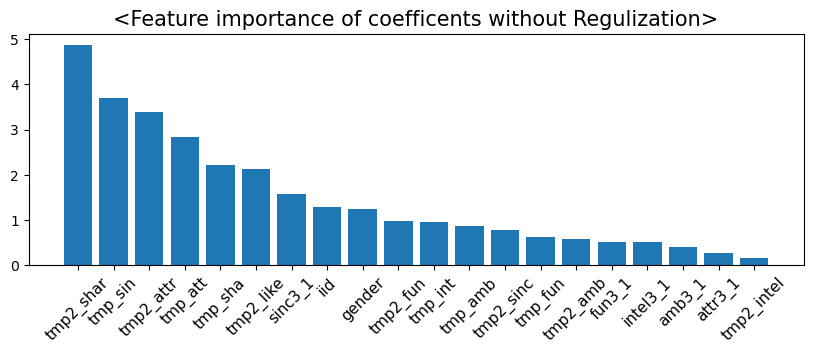

In [14]:
coef = LR_coef.sort_values(ascending=False)
coef = np.abs(LR_coef).sort_values(ascending=False)
# print('======')
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents without Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [15]:
# 모델별 비교 데이터프레임 열 추가
comp_df["LR"] = np.append(model_LR.coef_, r2)
comp_df

,LR
iid,1.280159
gender,1.237282
attr3_1,0.252238
sinc3_1,1.578972
intel3_1,0.500427
fun3_1,0.512621
amb3_1,0.387214
tmp_att,-2.844377
tmp_sin,-3.695316
tmp_int,-0.956110


####  데이터셋에 대한 설명 및 정보 확인

In [16]:
# 데이터 csv 불러오기
train = pd.read_csv('../data/train3.csv')

In [17]:
# Unnamed: 0 column제거
train = train.iloc[:,1:]
# 소수점 2자리까지
train.match = round(train.match, 2)

In [18]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1. 릿지 모델

In [19]:
from sklearn.linear_model import Ridge

model_Ridge = Ridge(alpha=1)
model_Ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [20]:
# 릿지 선형회귀 모델 평가: model_Ridge1, alpha=1
y_pred = model_Ridge.predict(X_test)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(r2)
# a=1일때 회귀 계수 확인

Ridge_coef = pd.Series(model_Ridge.coef_, index=X.columns)
Ridge_coef

0.15144369148335468


iid           0.008453
gender        2.428098
attr3_1       0.179584
sinc3_1       1.092450
intel3_1      0.443488
fun3_1        0.329410
amb3_1        0.207067
tmp_att      -0.239298
tmp_sin      -0.493005
tmp_int      -0.134245
tmp_fun       0.094226
tmp_amb      -0.132918
tmp_sha      -0.329465
tmp2_attr     2.546567
tmp2_sinc     0.734506
tmp2_intel   -0.152827
tmp2_fun     -0.760198
tmp2_amb      0.529438
tmp2_shar     3.449310
tmp2_like     1.707656
dtype: float64

- 계수값 시각화

In [21]:
pd.Series(np.abs(Ridge_coef), index=X.columns)

iid           0.008453
gender        2.428098
attr3_1       0.179584
sinc3_1       1.092450
intel3_1      0.443488
fun3_1        0.329410
amb3_1        0.207067
tmp_att       0.239298
tmp_sin       0.493005
tmp_int       0.134245
tmp_fun       0.094226
tmp_amb       0.132918
tmp_sha       0.329465
tmp2_attr     2.546567
tmp2_sinc     0.734506
tmp2_intel    0.152827
tmp2_fun      0.760198
tmp2_amb      0.529438
tmp2_shar     3.449310
tmp2_like     1.707656
dtype: float64

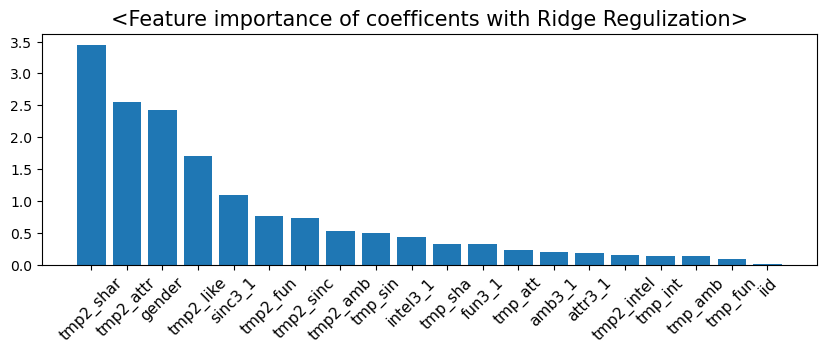

In [22]:
coef = pd.Series(np.abs(Ridge_coef), index=X.columns)
coef = coef.sort_values(ascending=False)
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Ridge Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [23]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 1, 10, 100]

for each in alpha_list:
    model_Ridge = Ridge(alpha=each)
    model_Ridge.fit(X_train, y_train)
    
    y_pred = model_Ridge.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'Ridge(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_Ridge.coef_, r2)

In [24]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00)
iid,1.280159,0.008460,0.008453,0.008391,0.007952
gender,1.237282,2.474192,2.428098,2.074145,0.811326
attr3_1,0.252238,0.178421,0.179584,0.190681,0.283197
sinc3_1,1.578972,1.091565,1.092450,1.098078,1.059285
intel3_1,0.500427,0.443866,0.443488,0.438512,0.364319
fun3_1,0.512621,0.332826,0.329410,0.303775,0.240203
amb3_1,0.387214,0.206253,0.207067,0.212928,0.221180
tmp_att,-2.844377,-0.240758,-0.239298,-0.227847,-0.177541
tmp_sin,-3.695316,-0.493751,-0.493005,-0.487134,-0.459123
tmp_int,-0.956110,-0.134873,-0.134245,-0.129274,-0.105437


### 2. 라쏘 모델

In [25]:
from sklearn.linear_model import Lasso

# alpha=1인 경우(default)
model_Lasso = Lasso(alpha=1)
model_Lasso.fit(X_train, y_train)

Lasso(alpha=1)

In [48]:
# 라쏘 선형회귀 모델 평가(alpha=1)
# 선형 모델 평가
y_pred = model_Lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
#a = 1 라쏘 모델 회귀 계수
Lasso_coef = pd.Series(model_Lasso.coef_, index=X.columns)
Lasso_coef

TypeError: 'numpy.float64' object is not callable

- 계수 시각화

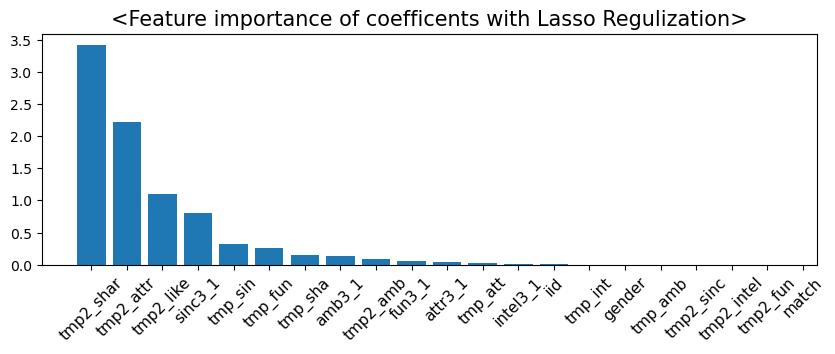

In [27]:
coef = np.abs(Lasso_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Lasso Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [28]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 1, 10, 100]

for each in alpha_list:
    model_Lasso = Lasso(alpha=each)
    model_Lasso.fit(X_train, y_train)
    
    y_pred = model_Lasso.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'Lasso(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_Lasso.coef_, r2)

In [29]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00),Lasso(alpha=0.01),Lasso(alpha=1.00),Lasso(alpha=10.00),Lasso(alpha=100.00)
iid,1.280159,0.008460,0.008453,0.008391,0.007952,0.008459,0.008054,0.004850,0.000313
gender,1.237282,2.474192,2.428098,2.074145,0.811326,2.406214,0.000000,-0.000000,0.000000
attr3_1,0.252238,0.178421,0.179584,0.190681,0.283197,0.177600,0.039569,0.000000,0.000000
sinc3_1,1.578972,1.091565,1.092450,1.098078,1.059285,1.095121,0.798823,0.000000,0.000000
intel3_1,0.500427,0.443866,0.443488,0.438512,0.364319,0.437545,0.011865,0.000000,0.000000
fun3_1,0.512621,0.332826,0.329410,0.303775,0.240203,0.327434,0.052449,0.000000,0.000000
amb3_1,0.387214,0.206253,0.207067,0.212928,0.221180,0.208667,0.138855,0.000000,0.000000
tmp_att,-2.844377,-0.240758,-0.239298,-0.227847,-0.177541,-0.234264,-0.029810,0.000000,0.000000
tmp_sin,-3.695316,-0.493751,-0.493005,-0.487134,-0.459123,-0.488195,-0.323891,-0.276348,-0.000000
tmp_int,-0.956110,-0.134873,-0.134245,-0.129274,-0.105437,-0.129834,0.000000,-0.000000,-0.000000


### 3. 엘라스틱넷 모델

In [30]:
from sklearn.linear_model import ElasticNet
# 모델 구축 및 학습(alpha=1, l1_ratio=0.5)

model_ElasticNet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_ElasticNet.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [31]:
#모델 평가 및 회귀 계수 확인
# 엘라스틱넷 선형회귀 모델 평가(alpha=1, L1_ratio=0.5)
# 선형 모델 평가
y_pred = model_ElasticNet.predict(X_test)
y_pred[y_pred < 0] = 0.

r2 = r2_score(y_test, y_pred)
print(r2)
evaluate_score(y_test, y_pred)
#a = 1 엘라스틱넷 모델 회귀 계수
ElasticNet_coef = pd.Series(model_ElasticNet.coef_, index=X.columns)

0.15293493911522138
mse- 482.256
rmse- 21.960
r2- 0.153


- 계수 시각화

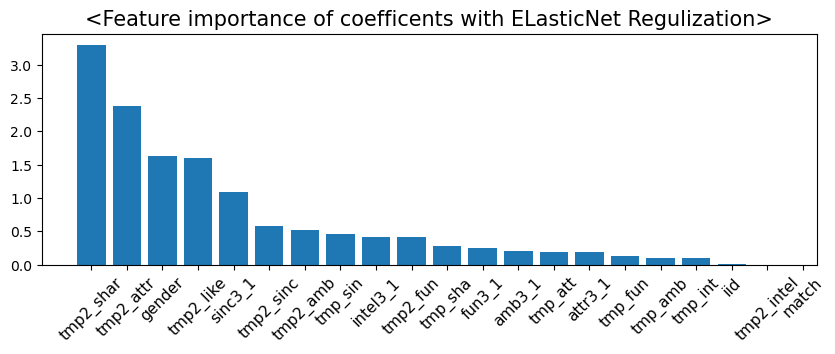

In [32]:
coef = np.abs(ElasticNet_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with ELasticNet Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [33]:
# alpha_list=[0.01, 1, 10, 100]인 경우, l1_ratio=0.5 

alpha_list = [0.01, 1, 10, 100]

for each in alpha_list:
    model_ElasticNet = ElasticNet(alpha=each)
    model_ElasticNet.fit(X_train, y_train)
    
    y_pred = model_ElasticNet.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'ElasticNet(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_ElasticNet.coef_, r2)
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00),Lasso(alpha=0.01),Lasso(alpha=1.00),Lasso(alpha=10.00),Lasso(alpha=100.00),ElasticNet(alpha=0.01),ElasticNet(alpha=1.00),ElasticNet(alpha=10.00),ElasticNet(alpha=100.00)
iid,1.280159,0.008460,0.008453,0.008391,0.007952,0.008459,0.008054,0.004850,0.000313,0.008448,0.007732,0.005375,0.002491
gender,1.237282,2.474192,2.428098,2.074145,0.811326,2.406214,0.000000,-0.000000,0.000000,2.365298,0.000000,0.000000,0.000000
attr3_1,0.252238,0.178421,0.179584,0.190681,0.283197,0.177600,0.039569,0.000000,0.000000,0.179964,0.241542,0.000000,0.000000
sinc3_1,1.578972,1.091565,1.092450,1.098078,1.059285,1.095121,0.798823,0.000000,0.000000,1.094704,0.840820,0.000000,0.000000
intel3_1,0.500427,0.443866,0.443488,0.438512,0.364319,0.437545,0.011865,0.000000,0.000000,0.440074,0.142755,0.000000,0.000000
fun3_1,0.512621,0.332826,0.329410,0.303775,0.240203,0.327434,0.052449,0.000000,0.000000,0.324581,0.185969,0.000000,0.000000
amb3_1,0.387214,0.206253,0.207067,0.212928,0.221180,0.208667,0.138855,0.000000,0.000000,0.208735,0.163849,0.000000,0.000000
tmp_att,-2.844377,-0.240758,-0.239298,-0.227847,-0.177541,-0.234264,-0.029810,0.000000,0.000000,-0.235147,-0.048918,0.000000,0.000000
tmp_sin,-3.695316,-0.493751,-0.493005,-0.487134,-0.459123,-0.488195,-0.323891,-0.276348,-0.000000,-0.489775,-0.349214,-0.300356,-0.000000
tmp_int,-0.956110,-0.134873,-0.134245,-0.129274,-0.105437,-0.129834,0.000000,-0.000000,-0.000000,-0.131341,-0.000000,-0.000000,-0.000000


# Scaling, GridSerchCV

####  데이터셋에 대한 설명 및 정보 확인

In [34]:
# 데이터 csv 불러오기
train = pd.read_csv('../data/train3.csv')

In [35]:
# Unnamed: 0 column제거
train = train.iloc[:,1:]
# 소수점 2자리까지
train.match = round(train.match, 2)

In [36]:
# X(독립변수), Y(종속변수) 분할
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 릿지 모델 scaling, GridSerchCV

### 라쏘 모델 scaling, GridSerchCV

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 데이터 로드
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 파이프라인 정의
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

# 탐색할 하이퍼파라미터 값 지정
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1, 10, 100]
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# 모델 학습
grid_search.fit(X, y)

# 최적의 모델 선택
best_model = grid_search.best_estimator_

# 최적의 하이퍼파라미터 출력
print("Best Parameters: ", grid_search.best_params_)

# 예측
y_pred = best_model.predict(X)
y_pred[y_pred < 0] = 0.
# 모델 성능 평가
r2_score = best_model.score(X, y)
mse = mean_squared_error(y, y_pred)

# 결과 출력
print("R^2 Score: ", r2_score)
print("MSE: ", mse)

Best Parameters:  {'lasso__alpha': 1}
R^2 Score:  0.15488430156037003
MSE:  553.0074689768298


In [47]:
# 라쏘 선형회귀 모델 평가(alpha=1)
# 선형 모델 평가
y_pred = best_model.predict(X_test)
#a = 1 라쏘 모델 회귀 계수
Lasso_coef = pd.Series(best_model.named_steps['lasso'].coef_, index=X.columns)
Lasso_coef

iid           0.000000
gender        0.000000
attr3_1       0.000000
sinc3_1       0.000000
intel3_1      0.462740
fun3_1        0.287577
amb3_1        0.167076
tmp_att       0.000000
tmp_sin      -0.647065
tmp_int       0.000000
tmp_fun       0.246166
tmp_amb      -0.000000
tmp_sha      -0.207122
tmp2_attr     3.585846
tmp2_sinc     0.512190
tmp2_intel    0.572446
tmp2_fun      0.358464
tmp2_amb      0.287542
tmp2_shar     3.883727
tmp2_like     1.097139
dtype: float64

- 계수 시각화

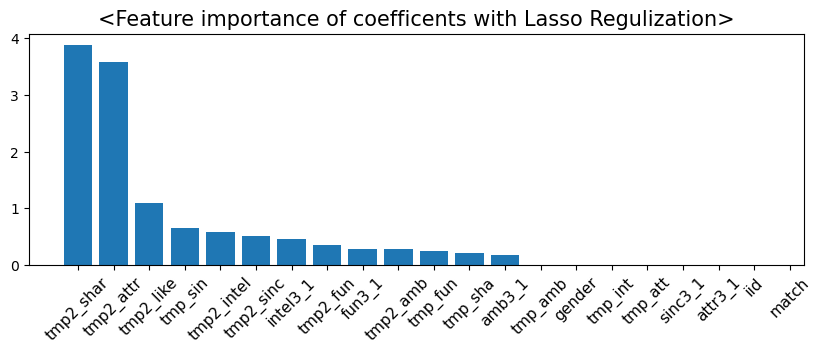

In [49]:
coef = np.abs(Lasso_coef)
coef = pd.Series(coef, index=train.columns).sort_values(ascending=False)
coef
# 시각화
plt.figure(figsize=(10,3))
plt.title('<Feature importance of coefficents with Lasso Regulization>', fontsize=15)
plt.bar(coef.index, coef.values)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [28]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list = [0.01, 0.1, 1, 10, 100]

for each in alpha_list:
    model_Lasso = Lasso(alpha=each)
    model_Lasso.fit(X_train, y_train)
    
    y_pred = model_Lasso.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'Lasso(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_Lasso.coef_, r2)

In [29]:
# comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00),Lasso(alpha=0.01),Lasso(alpha=1.00),Lasso(alpha=10.00),Lasso(alpha=100.00)
iid,1.280159,0.008460,0.008453,0.008391,0.007952,0.008459,0.008054,0.004850,0.000313
gender,1.237282,2.474192,2.428098,2.074145,0.811326,2.406214,0.000000,-0.000000,0.000000
attr3_1,0.252238,0.178421,0.179584,0.190681,0.283197,0.177600,0.039569,0.000000,0.000000
sinc3_1,1.578972,1.091565,1.092450,1.098078,1.059285,1.095121,0.798823,0.000000,0.000000
intel3_1,0.500427,0.443866,0.443488,0.438512,0.364319,0.437545,0.011865,0.000000,0.000000
fun3_1,0.512621,0.332826,0.329410,0.303775,0.240203,0.327434,0.052449,0.000000,0.000000
amb3_1,0.387214,0.206253,0.207067,0.212928,0.221180,0.208667,0.138855,0.000000,0.000000
tmp_att,-2.844377,-0.240758,-0.239298,-0.227847,-0.177541,-0.234264,-0.029810,0.000000,0.000000
tmp_sin,-3.695316,-0.493751,-0.493005,-0.487134,-0.459123,-0.488195,-0.323891,-0.276348,-0.000000
tmp_int,-0.956110,-0.134873,-0.134245,-0.129274,-0.105437,-0.129834,0.000000,-0.000000,-0.000000


#### 예측값

In [38]:
y_pred

array([46.79358396, 22.60534369, 16.83629138, 21.3204111 , 16.26241246,
       46.97691105, 46.62056964, 25.71896022, 13.13072982, 14.0266248 ,
       30.36921737, 12.41627639, 31.30085879, 19.95819446, 24.15420858,
       16.61199728, 34.98215566, 32.97148934,  9.34602979, 23.08714157,
        4.41124202, 18.02519565, 17.41563252, 21.90824833, 12.05473018,
       12.92394995, 24.76518341, 19.86922225, 15.09592453, 16.88193074,
       19.88318158, 16.01690724, 14.77233419, 42.81469656, 21.65498603,
       17.31823347,  0.        ,  8.73201474,  7.44123391, 15.35681278,
        5.55228907, 19.31225963, 27.23758768, 13.26764626, 11.35757489,
       21.23080058,  8.52005359, 27.28186937, 21.29950794, 16.97140341,
       10.21847863, 27.47491767, 18.9876166 , 16.94829805, 17.41439548,
       26.3498347 , 25.56386317, 23.42167256, 20.7463175 , 24.94958508,
       19.0681141 , 12.21189129, 19.2748562 , 18.58166092, 19.24706084,
       13.27282358, 27.00881575, 24.07972614, 44.30983913, 32.91

### SGDRegressor의 엘라스틱넷규제 모델 scaling, GridSerchCV

In [53]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# 데이터셋을 훈련용과 테스트용으로 분리
X = train.drop('match', axis=1)
y = train['match']
# 학습용 데이터와 평가용 데이터로 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 파이프라인 생성
model = make_pipeline(
    StandardScaler(),
    SGDRegressor(loss='squared_error', penalty='elasticnet', random_state=42)
)

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
param_grid = {
    'sgdregressor__alpha': [0.001, 0.01, 0.1, 1.7, 10, 100],
    'sgdregressor__l1_ratio': [0.05, 0.1, 0.15, 0.5, 0.75, 0.9],
    'sgdregressor__max_iter': [100],
}

grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best parameters: ", grid.best_params_)

# 최적의 모델로 성능 평가
score = grid.score(X_test, y_test)
print("R-squared score: {:.3f}".format(score))

Best parameters:  {'sgdregressor__alpha': 1.7, 'sgdregressor__l1_ratio': 0.1, 'sgdregressor__max_iter': 100}
R-squared score: 0.189


In [54]:
# 최적의 하이퍼파라미터로 모델 재학습
best_model = make_pipeline(
    StandardScaler(),
    SGDRegressor(loss='squared_error', penalty='elasticnet',
                 alpha=grid.best_params_['sgdregressor__alpha'],
                 l1_ratio=grid.best_params_['sgdregressor__l1_ratio'],
                 max_iter=grid.best_params_['sgdregressor__max_iter'],
                 random_state=42)
)
best_model.fit(X_train, y_train)
# 회귀 계수 출력
coefficients = 
print("회귀 계수: ", coefficients)

회귀 계수:  [ 0.30304434  0.16993285  0.64267028  0.41724518  0.18706021  0.53027903
  0.21283153  0.09277349 -1.03155219  0.          0.93159985  0.
 -0.36925147  1.8286339   0.73815647  0.60301331  1.04738796  0.84171467
  1.9656149   1.62571988]


In [56]:
#모델 회귀 계수
ElasticNet_coef = pd.Series(best_model.named_steps['sgdregressor'].coef_, index=X.columns)
ElasticNet_coef

iid           0.303044
gender        0.169933
attr3_1       0.642670
sinc3_1       0.417245
intel3_1      0.187060
fun3_1        0.530279
amb3_1        0.212832
tmp_att       0.092773
tmp_sin      -1.031552
tmp_int       0.000000
tmp_fun       0.931600
tmp_amb       0.000000
tmp_sha      -0.369251
tmp2_attr     1.828634
tmp2_sinc     0.738156
tmp2_intel    0.603013
tmp2_fun      1.047388
tmp2_amb      0.841715
tmp2_shar     1.965615
tmp2_like     1.625720
dtype: float64

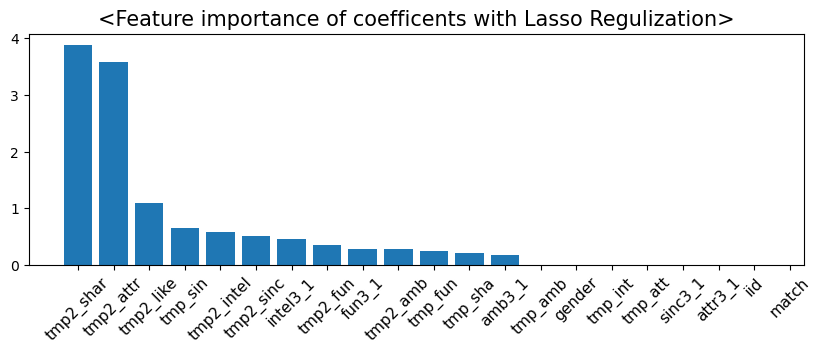

In [57]:
# alpha_list=[0.01, 1, 10, 100]인 경우, l1_ratio=0.5 
alpha_list = [0.01, 1, 10, 100]

for each in alpha_list:
    model_ElasticNet = ElasticNet(alpha=each)
    model_ElasticNet.fit(X_train, y_train)
    
    y_pred = model_ElasticNet.predict(X_test)
    y_pred[y_pred < 0] = 0.
    
    r2 = r2_score(y_test, y_pred)
    col_name = f'ElasticNet(alpha={each:.2f})'
    
    comp_df[col_name] = np.append(model_ElasticNet.coef_, r2)
comp_df

#### 예측값

In [58]:
y_pred = grid.predict(X_test)
print("Predictions: ", y_pred)

Predictions:  [18.33352641 14.4961429  15.77675552 30.70854311 13.09683176 39.65003941
 21.17551024 22.02505616 29.40215583 25.1542304   9.40380743 11.27693072
 28.52528592 21.81143067 21.27958017  9.24300649  0.30354359 23.21169185
 22.10927671 12.91800946 17.91660634 41.60860777 26.77509771 12.81080171
 19.12251535 19.03627998 45.34038948 13.56533061 21.07017794 20.19690231
 14.68858306 34.22503987 25.45426514 22.47763626 21.01505861 11.17943994
 13.23284883 26.1245083  21.47912887  9.4074932  28.35374283  9.65117798
 10.2010416  26.26206423 32.87482539 16.0422614   7.61495111 18.91005796
 20.10524752 27.00015219 17.13944971 19.86661542 14.1534852  27.05241126
  7.52601331 20.46102484 18.81018345 17.64832653 21.98081697  4.2268403
 20.12653969 19.12582221 16.53622678 13.51404946 21.70499679 28.60254802
 23.01087529  9.86374478 29.56118233 18.85060901 15.35518379 19.44767967
 16.1299631  14.86957503 12.7261117  22.63945404 22.03726238 14.46858627
 28.26700824 12.76142104 21.14340827 1